Check Data Distribution: Ensure the dataset is balanced among the categories. A skewed distribution can cause the model to predict the most frequent class.
Increase Dropout: To help with overfitting, especially given your issue with converging on a single class.
Modify the Transformer Setup: Adjust parameters like the number of heads and layers, especially if your model complexity doesn't match the task complexity.
Learning Rate Scheduler: Implement a scheduler to adjust the learning rate during training, which can help in better convergence.
Model Regularization: Consider adding batch normalization layers to stabilize the learning process.
Increase Epochs: As suggested by your TA, increasing the number of training epochs might help, but first ensure that the model architecture and learning rate are optimally set.

In [1]:
from socket import gethostname
gethostname()

'hpc3-gpu-24-01'

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [6]:
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

class_counts = {"angry": 3995, "disgust": 436, "fear": 4097, "happy": 7215, "neutral": 4965, "sad": 4830, "surprise":3171}

weights = [1.0 / counts for counts in class_counts.values()]
labels = train_dataset.classes
sample_weights = [weights[label] for _, label in train_dataset.samples]

# Create sampler and DataLoader for training
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, sampler=sampler, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model and move it to device
class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Increased percentage dropped to combat overfitting
            nn.Dropout(0.5)
        )
        self.output_layer = nn.Linear(256*3*3, 7)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 256*3*3)
        x = self.output_layer(x)
        return x

# Initialize model, optimizer, loss function, and scheduler
model = FERModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# scheduler = ExponentialLR(optimizer, gamma=0.95)

# Lists to store metrics
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_acc.append(correct / total)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_acc.append(correct / total)


    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {train_acc[-1]}, Val Acc: {val_acc[-1]}')



Using device: cuda


Epoch 1/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:52<00:00, 17.07it/s]


Epoch 1, Train Loss: 1.8215284072442208, Val Loss: 1.547000573650646, Train Acc: 0.3178794106377791, Val Acc: 0.4165505711897464


Epoch 2/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.39it/s]


Epoch 2, Train Loss: 1.4695167114893353, Val Loss: 1.3760425895161867, Train Acc: 0.4513218851231321, Val Acc: 0.4641961549178044


Epoch 3/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.36it/s]


Epoch 3, Train Loss: 1.3024273501439396, Val Loss: 1.2991779317560883, Train Acc: 0.5117558953638232, Val Acc: 0.5032042351629981


Epoch 4/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.52it/s]


Epoch 4, Train Loss: 1.198013131855764, Val Loss: 1.2734435178603127, Train Acc: 0.5544602737817409, Val Acc: 0.5199219838395096


Epoch 5/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.31it/s]


Epoch 5, Train Loss: 1.1280170730290657, Val Loss: 1.2259461218498982, Train Acc: 0.5754293078825455, Val Acc: 0.5409584842574533


Epoch 6/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.38it/s]


Epoch 6, Train Loss: 1.075239683145133, Val Loss: 1.1504950772407294, Train Acc: 0.5959803545926364, Val Acc: 0.5696572861521315


Epoch 7/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:57<00:00, 15.64it/s]


Epoch 7, Train Loss: 1.0185033236577545, Val Loss: 1.1235391488893014, Train Acc: 0.61701905325856, Val Acc: 0.5835887433825578


Epoch 8/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:54<00:00, 16.42it/s]


Epoch 8, Train Loss: 0.9815561611797955, Val Loss: 1.1253164222344079, Train Acc: 0.6325890835626459, Val Acc: 0.5757871273335191


Epoch 9/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:55<00:00, 16.15it/s]


Epoch 9, Train Loss: 0.9484939127740053, Val Loss: 1.0827567931768056, Train Acc: 0.6474973004981016, Val Acc: 0.5986347171914183


Epoch 10/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:52<00:00, 17.01it/s]


Epoch 10, Train Loss: 0.9302974263948808, Val Loss: 1.0741954020933708, Train Acc: 0.6538716082064858, Val Acc: 0.6095012538311507


Epoch 11/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.46it/s]


Epoch 11, Train Loss: 0.8962567537081454, Val Loss: 1.1012864816143972, Train Acc: 0.6669685464488488, Val Acc: 0.6001671774867651


Epoch 12/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.55it/s]


Epoch 12, Train Loss: 0.8893729778428848, Val Loss: 1.0873226298408012, Train Acc: 0.6685708314465847, Val Acc: 0.5991919754806353


Epoch 13/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.80it/s]


Epoch 13, Train Loss: 0.8551488291561602, Val Loss: 1.083693786629331, Train Acc: 0.6810059563203177, Val Acc: 0.6033714126497631


Epoch 14/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.78it/s]


Epoch 14, Train Loss: 0.8394695461603985, Val Loss: 1.0715322333247126, Train Acc: 0.6858824758786444, Val Acc: 0.6095012538311507


Epoch 15/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.48it/s]


Epoch 15, Train Loss: 0.817537147886946, Val Loss: 1.082082086608881, Train Acc: 0.6955310181476192, Val Acc: 0.6088046809696295


In [7]:
print(model)

FERModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_loader is your DataLoader for the test dataset
true_labels = []
predicted_labels = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average="weighted")
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Overall Accuracy: 0.6088
F1 Score: 0.6058


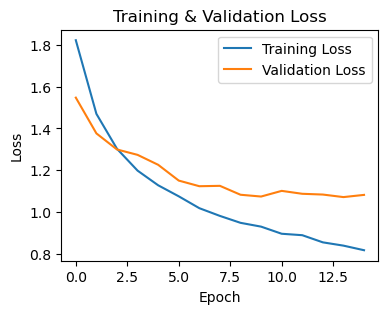

In [9]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

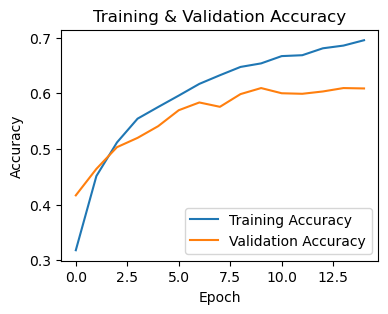

In [10]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

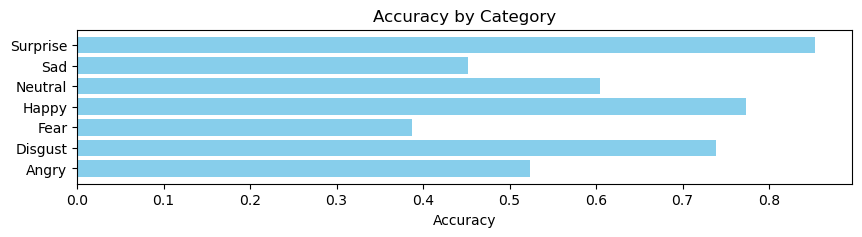

In [12]:
import numpy as np

category_accuracies = []
for i in range(7):
    category_mask = (np.array(true_labels) == i)
    category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
    category_accuracies.append(category_acc)

# Plotting category accuracies
categories = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
ax.barh(range(7), category_accuracies, color='skyblue')
ax.set_xlabel('Accuracy')
ax.set_yticks(range(7))
ax.set_yticklabels(categories)
ax.set_title('Accuracy by Category')
plt.show()

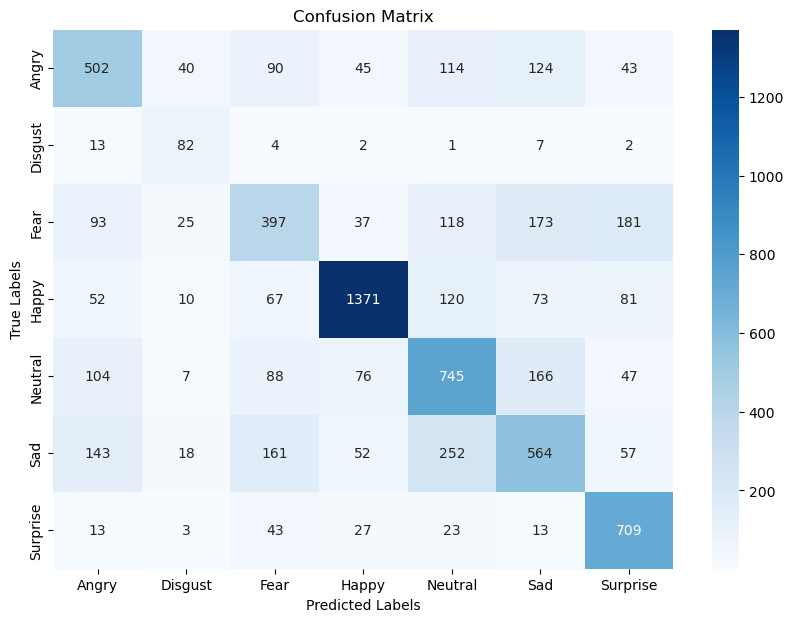

In [13]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
